In [1]:
"""
ARES BO Prior Results - Final Publication Plot (FODO Style)
"""

from typing import Dict, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scienceplots
import seaborn as sns
import torch
from matplotlib.colors import LogNorm, Normalize

import bo_cheetah_prior_ares as bo_cheetah_prior
import cheetah
from xopt import VOCS

# ============================================================================
# Plotting Styles (FODO)
# ============================================================================
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
plt.style.use(["science", "ieee", "no-latex"])

# ============================================================================
# Load Data
# ============================================================================
print("Loading ARES optimization results...")
df_nm_mismatched = pd.read_csv("data/NM_mismatched.csv")
df_bo_mismatched = pd.read_csv("data/BO_mismatched.csv")
df_bo_prior_mismatched = pd.read_csv("data/BO_prior_mismatched.csv")
#df_bo_prior_matched = pd.read_csv("data/BO_prior_matched.csv")
df_bo_prior_matched_newtask = pd.read_csv("data/BO_prior_matched_prior_newtask.csv")

print(f"✓ Loaded {len(df_nm_mismatched)} NM evaluations")
print(f"✓ Loaded {len(df_bo_mismatched)} BO evaluations")
print(f"✓ Loaded {len(df_bo_prior_mismatched)} BO_prior (mismatched) evaluations")
print(f"✓ Loaded {len(df_bo_prior_matched_newtask)} BO_prior (matched) evaluations")


Loading ARES optimization results...
✓ Loaded 655 NM evaluations
✓ Loaded 655 BO evaluations
✓ Loaded 655 BO_prior (mismatched) evaluations
✓ Loaded 655 BO_prior (matched) evaluations


In [2]:
# ============================================================================
# Calculate Reference Values
# ============================================================================
# Use best result as "true minimum" reference
true_minimum = min([
    df_nm_mismatched['mae'].min(),
    df_bo_mismatched['mae'].min(),
    df_bo_prior_mismatched['mae'].min(),
    df_bo_prior_matched_newtask['mae'].min()
])

print(f"\nBest result found: {true_minimum:.6e}")


Best result found: 2.550072e-05



Generating final plot...


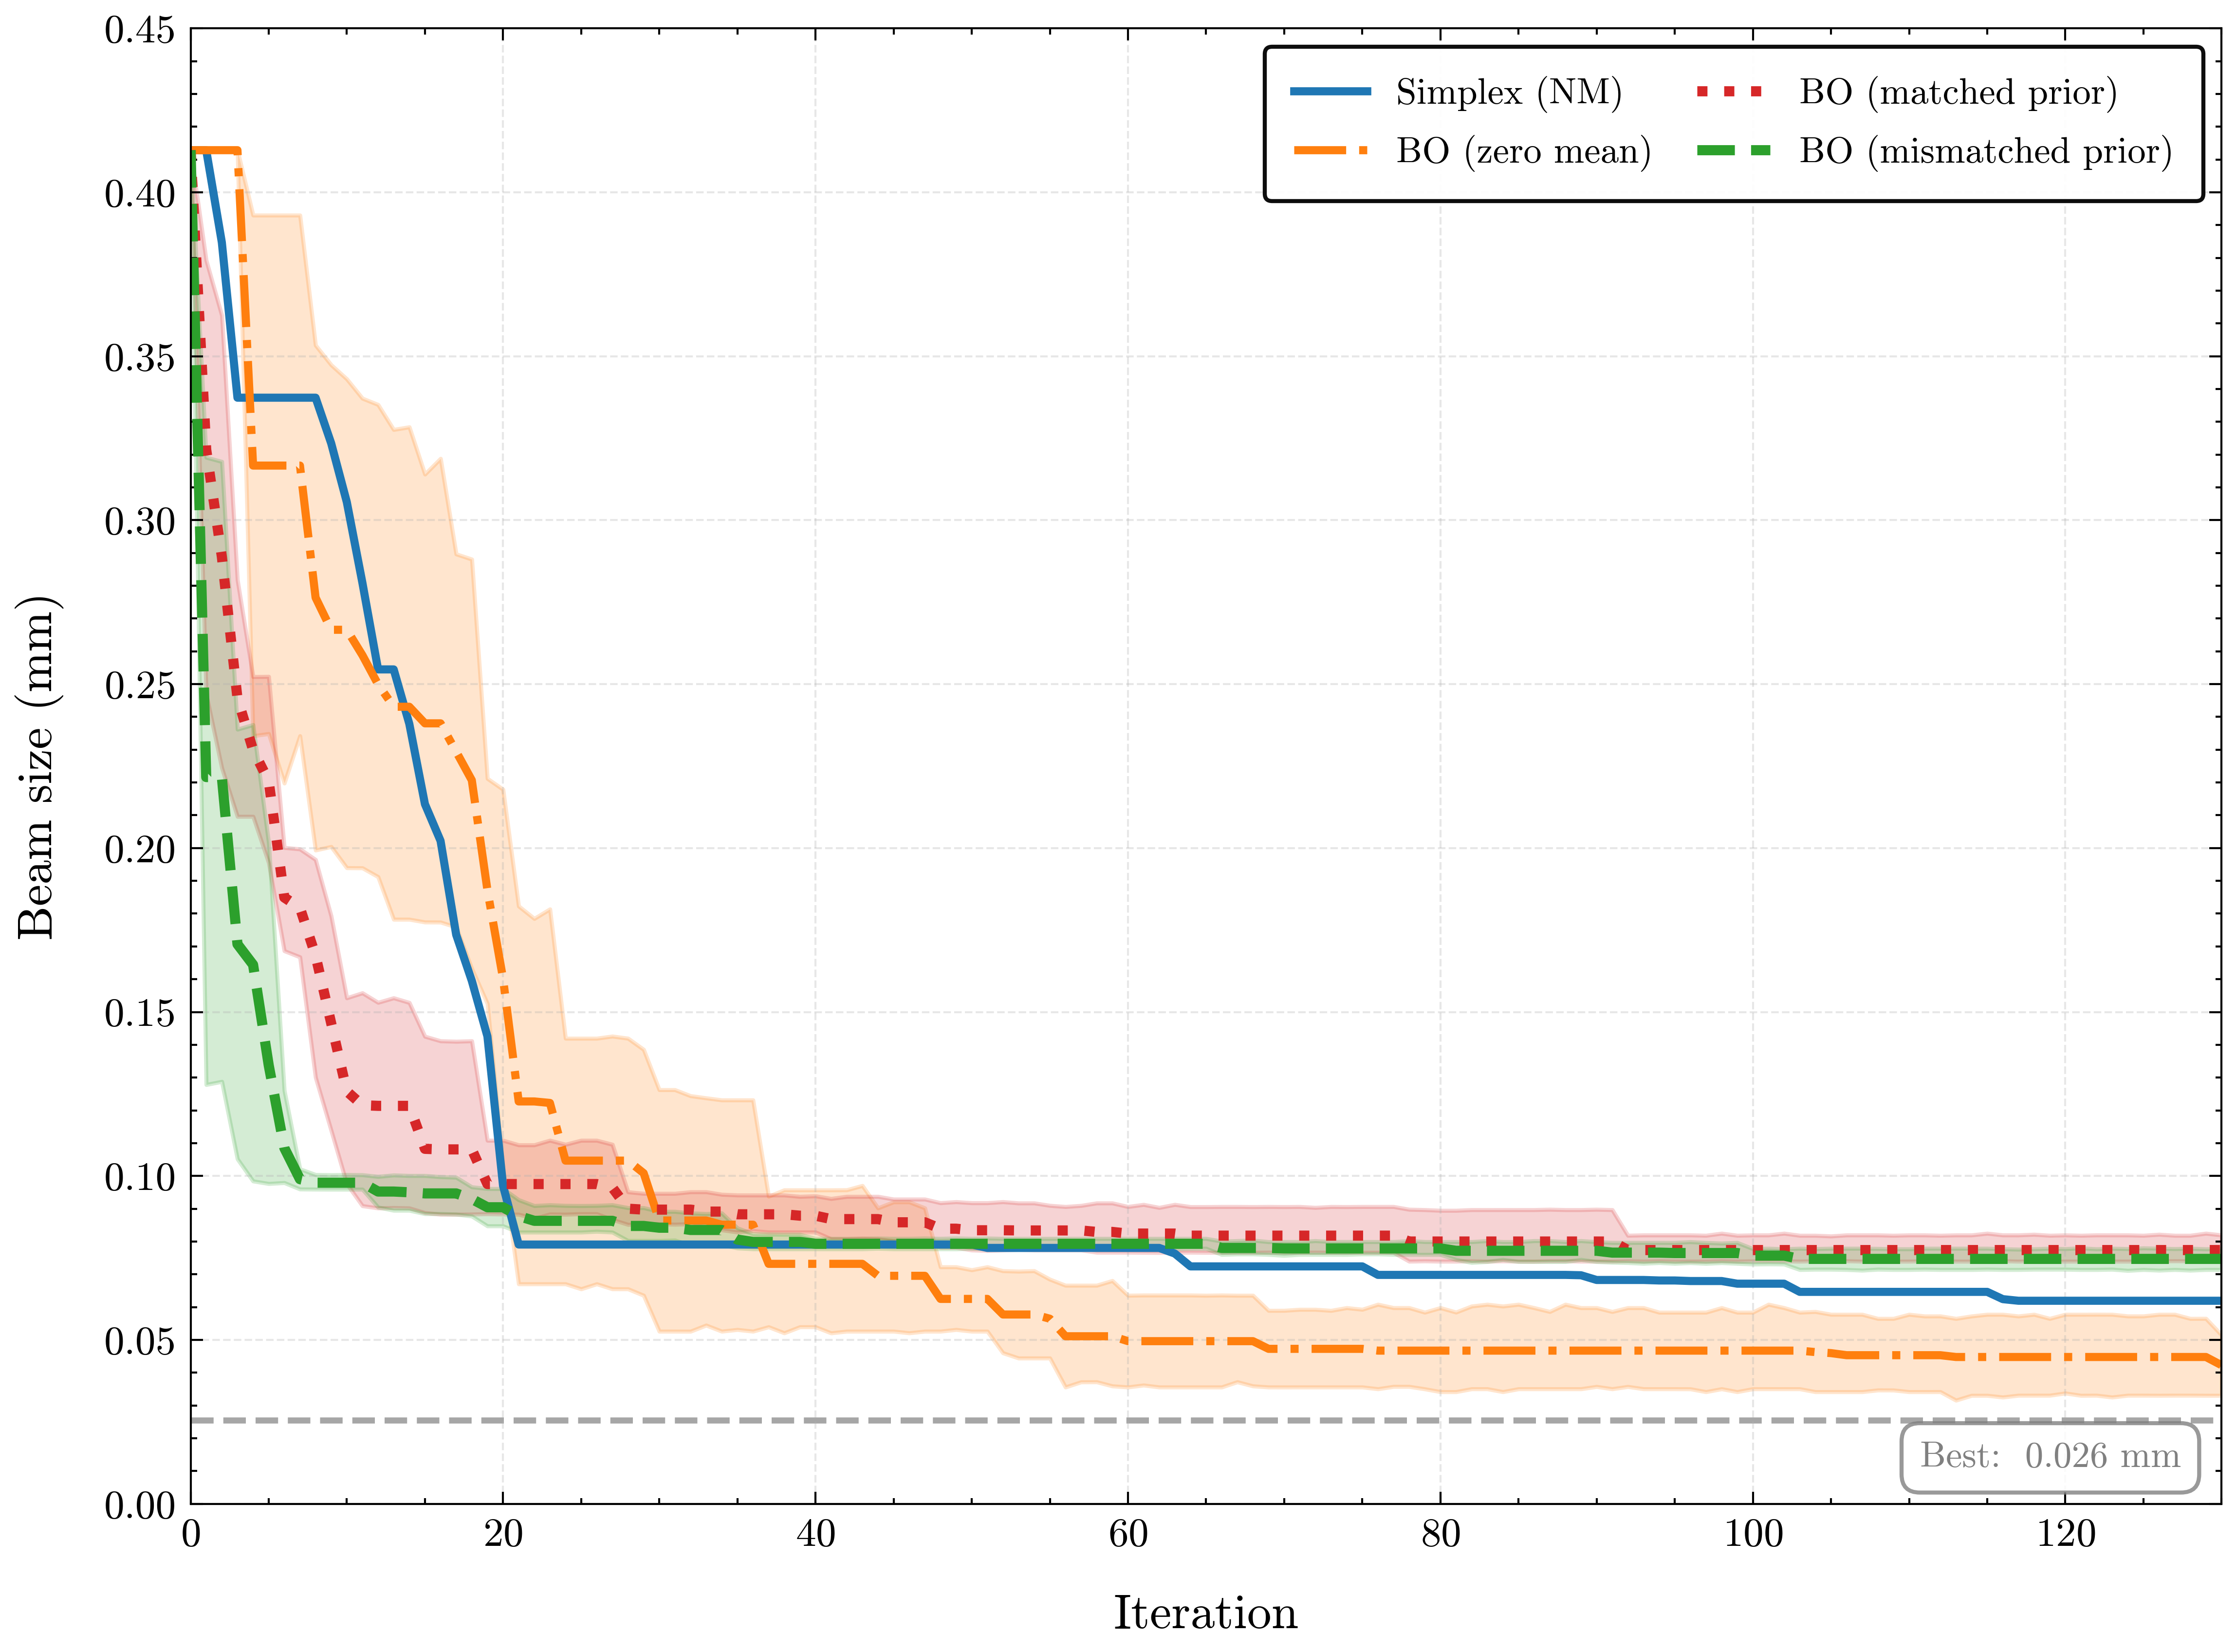

✓ Plot saved: ares_bo_prior_result.pdf


In [3]:
# ============================================================================
# Final Plot (FODO Style - Properly Sized)
# ============================================================================
print("\nGenerating final plot...")

# Create figure with generous size
fig, ax = plt.subplots(figsize=(8, 6))  # Larger figure for breathing room

# Reference line for best result
ax.axhline(y=true_minimum, color="grey", linestyle="--", 
           linewidth=1.5, alpha=0.7, zorder=1)

# Plot convergence curves
sns.lineplot(
    data=df_nm_mismatched,
    x="step",
    y="best_mae",
    ax=ax,
    label="Simplex (NM)",
    color=colors[0],
    ls="-",
    linewidth=2,
)

sns.lineplot(
    data=df_bo_mismatched,
    x="step",
    y="best_mae",
    ax=ax,
    label="BO (zero mean)",
    color=colors[1],
    ls="-.",
    linewidth=2,
)

sns.lineplot(
    data=df_bo_prior_matched_newtask,
    x="step",
    y="best_mae",
    ax=ax,
    label="BO (matched prior)",
    color=colors[3],
    ls=":",
    linewidth=2.5,
)

sns.lineplot(
    data=df_bo_prior_mismatched,
    x="step",
    y="best_mae",
    ax=ax,
    label="BO (mismatched prior)",
    color=colors[2],
    ls="--",
    linewidth=2.5,
)

# Add annotation for reference line (repositioned to avoid overlap)
ax.text(
    0.98,
    0.02,
    f"Best:  {true_minimum*1000:.3f} mm",
    transform=ax.transAxes,
    color="grey",
    ha="right",
    va="bottom",
    fontsize=9,
    bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='grey', alpha=0.8)
)

# Formatting with proper spacing
ax.set_ylabel("Beam size (mm)", fontsize=12, labelpad=10)  # Add padding
ax.set_xlabel("Iteration", fontsize=12, labelpad=10)
ax.set_xlim(0, df_bo_mismatched['step'].max())

# Convert y-axis to mm with cleaner formatting
yticks = ax.get_yticks()
ax.set_yticks(yticks)
ax.set_yticklabels([f'{y*1000:.2f}' for y in yticks], fontsize=10)
ax.tick_params(axis='x', labelsize=10)

# Legend positioned to avoid data overlap
ax.legend(
    ncol=2, 
    loc='upper right', 
    framealpha=0.95, 
    fontsize=9,
    frameon=True,
    edgecolor='black',
    borderpad=0.8,
    labelspacing=0.6,
    columnspacing=1.2
)

ax.grid(True, alpha=0.3, linestyle='--')

# Use tight_layout with padding to prevent clipping
fig.tight_layout(pad=2.0)  # Extra padding around plot

# Save with bbox_inches='tight' to ensure nothing is cut off
fig.savefig("ares_bo_prior_result.pdf", bbox_inches="tight", dpi=300, pad_inches=0.2)
fig.savefig("ares_bo_prior_result.png", bbox_inches="tight", dpi=300, pad_inches=0.2)
plt.show()

print("✓ Plot saved: ares_bo_prior_result.pdf")

In [4]:
# ============================================================================
# Summary Table
# ============================================================================
print("\n" + "="*70)
print("  ARES OPTIMIZATION RESULTS")
print("="*70)

def get_final_stats(df):
    """Get mean ± std of final best values across runs"""
    final_best = df.groupby('run')['best_mae'].last()
    return final_best.mean(), final_best.std(), df['mae'].min()

methods = [
    ("Nelder-Mead", df_nm_mismatched),
    ("BO (zero mean)", df_bo_mismatched),
    ("BO_prior (mismatched)", df_bo_prior_mismatched),
    ("BO_prior (matched)", df_bo_prior_matched_newtask),
]

print(f"\n{'Method':<30s} {'Mean ± Std (mm)':<25s} {'Best (mm)':<15s}")
print("-"*70)

for name, df in methods:
    mean, std, best = get_final_stats(df)
    print(f"{name:<30s} {mean*1000:.3f} ± {std*1000:.3f}        {best*1000:.3f}")

print("="*70)


  ARES OPTIMIZATION RESULTS

Method                         Mean ± Std (mm)           Best (mm)      
----------------------------------------------------------------------
Nelder-Mead                    0.062 ± 0.000        0.062
BO (zero mean)                 0.042 ± 0.012        0.026
BO_prior (mismatched)          0.075 ± 0.004        0.069
BO_prior (matched)             0.077 ± 0.005        0.073
